# Motivating figure

In [1]:
import jax
import datagen
import jax.numpy as jnp
import matplotlib.pyplot as plt

from functools import partial
from rebayes_mini import callbacks
from rebayes_mini.methods import gauss_filter as kf
from rebayes_mini.methods import generalised_bayes_filter as gbf
from rebayes_mini.methods import robust_filter as rfilter

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.linewidth"] = 3

cmap = {
    "KF-IW": "crimson",
    "WLF-IMQ": "dodgerblue",
    "KF": "lightseagreen",
    "WLF-MD": "gold",
    "KF-B": "darkorange",
}

## Process sample

In [3]:
key = jax.random.PRNGKey(314)

In [4]:
delta = 1.0
dynamics_covariance = 0.1
obs_covariance = 1.0
outlier_scale = 2.0
dgen = datagen.GaussMeanOutlierMovingObject2D(
    delta, dynamics_covariance, obs_covariance,
    outlier_proba=0.0,
    outlier_scale=outlier_scale,
)


In [5]:
initial_mean = initial_mean = jnp.array([0.0, 0.0, 1.0, 1.0])

n_steps = 20
dataset = dgen.sample(key, initial_mean, n_steps)

measurements_clean = dataset["observed"]
state = dataset["latent"]


outlier_scale = 2
xout = jnp.array([5, 10, 15])
measurements = measurements_clean[xout] * outlier_scale * jnp.array([-1, 1, -1])[:, None]


measurements = measurements_clean.at[xout].set(measurements)

In [6]:
ix = 1
y = measurements[:, ix]
yout = y[xout]

xrange = jnp.arange(n_steps)
is_outlier = jnp.isin(xrange, xout)

Text(0.5, 0, 'time')

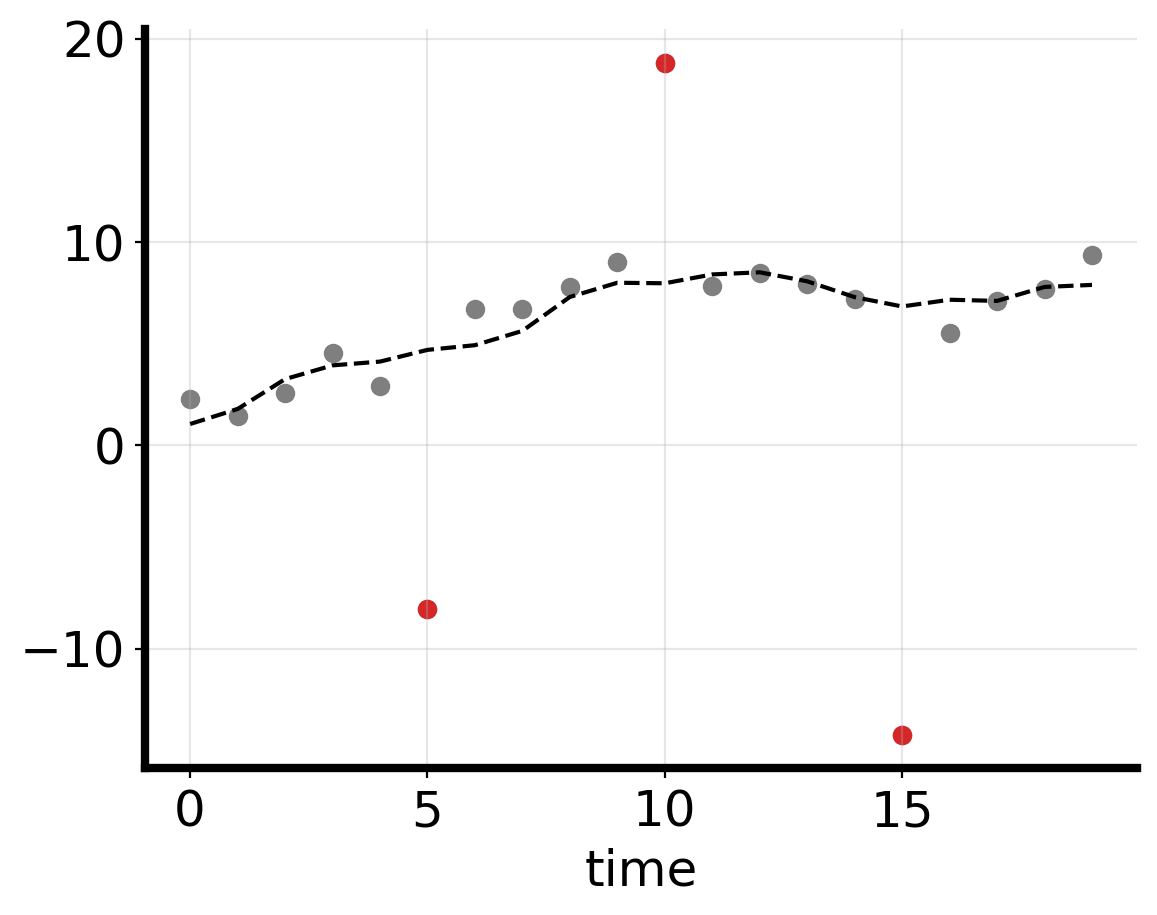

In [7]:
plt.plot(y, c="tab:gray", label="measurement", marker="o", linewidth=0, zorder=0)
plt.plot(state[:, ix], c="black", linestyle="--", label="state")
plt.scatter(xout, yout, c="tab:red")
plt.grid(alpha=0.3)
plt.xlabel("time")

In [8]:
def link(z, _):
    mean = dgen.projection_matrix @ z
    return mean


def callback(bel_update, bel_prev, y, x):
    return bel_update

In [9]:
agent_kf = kf.KalmanFilter(
    dgen.transition_matrix,
    dgen.dynamics_covariance,
    dgen.observation_covariance
)

init_bel = agent_kf.init_bel(initial_mean, cov=1.0)

bel, hist_noisy = agent_kf.scan(
    init_bel, measurements, dgen.projection_matrix,
    callback
)

## IMQ filter

In [10]:
soft_threshold = 2.0

agent_imq = rfilter.ExtendedKalmanFilterIMQ(
    lambda z: dgen.transition_matrix @ z,
    link,
    dynamics_covariance=dgen.dynamics_covariance,
    observation_covariance=dgen.observation_covariance,
    soft_threshold=soft_threshold,
)


init_bel = agent_imq.init_bel(initial_mean, cov=1.0)
_, hist = agent_imq.scan(init_bel, measurements, jnp.ones(n_steps), callback_fn=callback)

In [11]:
xrange = jnp.arange(0, n_steps)

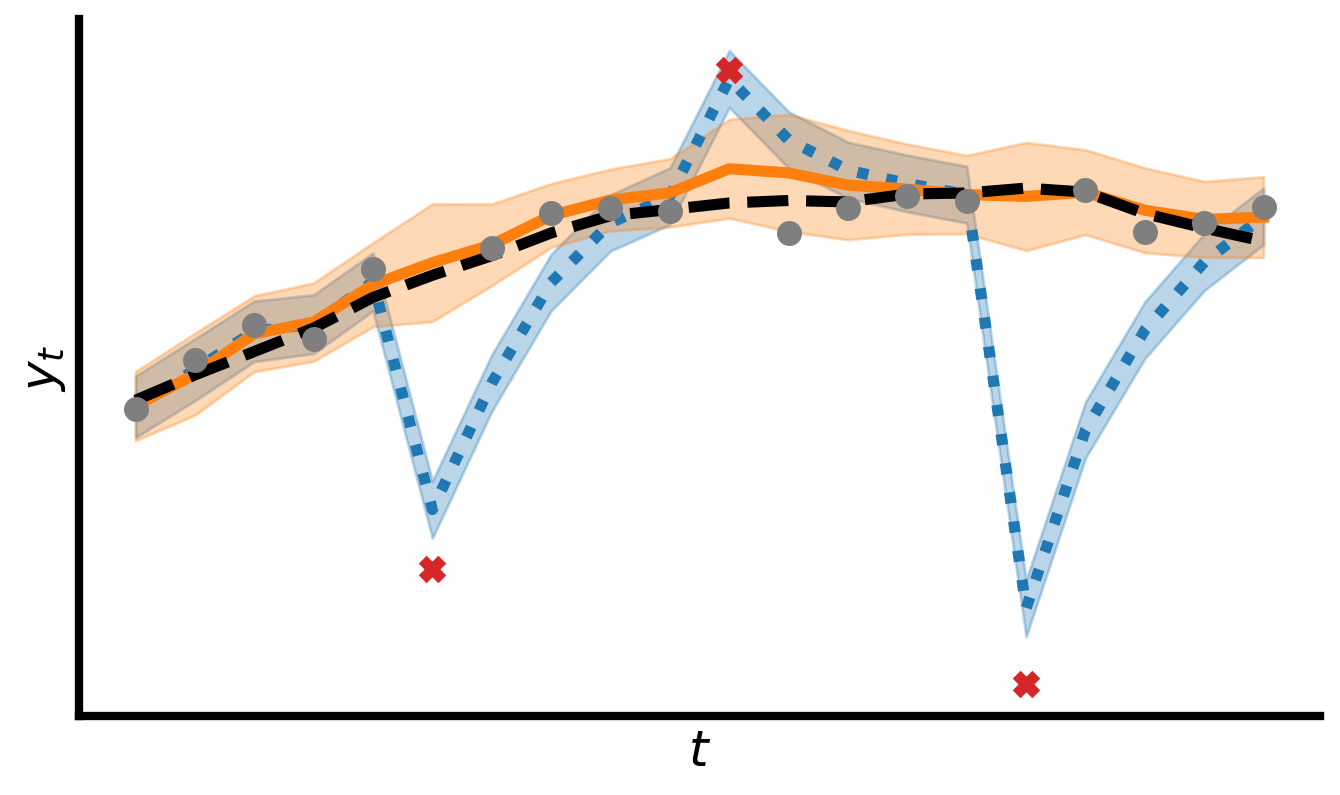

In [12]:
lw = 4
ix = 0
fig, ax = plt.subplots(figsize=(6.4 * 1.1, 4.8 * 0.9))

y = measurements[:, ix]

std_kf = jnp.sqrt(hist_noisy.cov[:, ix, ix])
std_wlkf = jnp.sqrt(hist.cov[:, ix, ix])


c = "tab:blue"
ubound =  hist_noisy.mean[:, ix] + 2  * std_kf
lbound =  hist_noisy.mean[:, ix] - 2 * std_kf
plt.fill_between(xrange, ubound, lbound, color=c, alpha=0.3)
plt.plot(xrange, hist_noisy.mean[:, ix], c=c, label="KF", linewidth=lw, linestyle="dotted")


c = "tab:orange"
ubound =  hist.mean[:, ix] + 2 * std_wlkf
lbound =  hist.mean[:, ix] - 2 * std_wlkf
plt.fill_between(xrange, ubound, lbound, color=c, alpha=0.3)
plt.plot(xrange, hist.mean[:, ix], c=c, label="WLF", linewidth=lw)


plt.plot(xrange, state[:, ix], c="black", linestyle="--", label="KF-clean", linewidth=lw)

# Plot outliers
plt.plot(xrange[~is_outlier], y[~is_outlier], c="tab:gray", marker="o", linewidth=0, markersize=8)
plt.scatter(xout, yout, c="tab:red", zorder=3, s=50, marker="x", linewidth=4)

# plt.grid(alpha=0.3)
plt.xticks([])
plt.yticks([])
plt.ylabel("$y_t$")
plt.xlabel("$t$")
plt.tight_layout()
plt.savefig("./figures/intro-plot.png", dpi=300)
# plt.legend(loc="upper left", fontsize=13)

## PIF effect

In [13]:
from matplotlib.colors import Normalize
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

2024-01-31 17:17:31.815810: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
def callback_prev(bel_update, bel_pred, y, x):
    err = dgen.projection_matrix @ bel_pred.mean - y
    return jnp.sqrt(jnp.power(err, 2).sum())


soft_threshold = 4.0
def callback_imq(bel_update, bel_pred, y, x):
    err = y - dgen.projection_matrix @ bel_pred.mean
    weighting_term = soft_threshold ** 2 / (soft_threshold ** 2 + jnp.inner(err, err))
    return weighting_term, bel_pred.mean


threshold = 4.0
def callback_md(bel_update, bel_pred, y, x):
    observation_precision = jnp.linalg.inv(dgen.observation_covariance)
    err = y - dgen.projection_matrix @ bel_pred.mean
    mahalanobis_distance = jnp.sqrt(jnp.einsum("j,jk,k->", err, observation_precision, err))
    weighting_term = (mahalanobis_distance < threshold).astype(float)
    return weighting_term, bel_pred.mean


def callback_kf(bel_update, bel_pred, y, x):
    return 1.0, bel_pred.mean

In [15]:
agent = kf.KalmanFilter(
    dynamics_covariance=dgen.dynamics_covariance,
    observation_covariance=dgen.observation_covariance,
    transition_matrix=dgen.transition_matrix,
)

init_bel = agent.init_bel(initial_mean, cov=1.0)
bel_base, _ = agent.scan(init_bel, measurements_clean, dgen.projection_matrix)

norm_base = tfd.MultivariateNormalFullCovariance(loc=bel_base.mean, covariance_matrix=bel_base.cov)

In [16]:
measurements_clean[n_steps -1]

Array([11.444289,  9.384666], dtype=float32)

In [17]:
xout = -1
@jax.jit
def pif_last(errx, erry):
    verr = jnp.array([errx, erry])
    measurements = measurements_clean.at[xout].set(measurements_clean[-1] + verr)

    soft_threshold = 4.0
    agent_imq = rfilter.ExtendedKalmanFilterIMQ(
        lambda x: dgen.transition_matrix @ x,
        link,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        soft_threshold=soft_threshold,
    )

    init_bel = agent_imq.init_bel(initial_mean, cov=1.0)
    bel_imq, out = agent_imq.scan(init_bel, measurements, jnp.ones(n_steps), callback_fn=callback_imq)
    w_imq, mean_pred_imq = jax.tree_map(lambda x: x[-1], out)

    norm_imq = tfd.MultivariateNormalFullCovariance(loc=bel_imq.mean, covariance_matrix=bel_imq.cov)
    

    threshold = 4.0
    agent_md = rfilter.ExtendedKalmanFilterMD(
        lambda x: dgen.transition_matrix @ x,
        link,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        threshold=threshold,
    )

    init_bel = agent_md.init_bel(initial_mean, cov=1.0)
    bel_md, out = agent_md.scan(init_bel, measurements, jnp.ones(n_steps), callback_fn=callback_md)
    w_md, mean_pred_md = jax.tree_map(lambda x: x[-1], out)

    norm_md = tfd.MultivariateNormalFullCovariance(loc=bel_md.mean, covariance_matrix=bel_md.cov)
    

    agent_kf = kf.KalmanFilter(
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        transition_matrix=dgen.transition_matrix,
    )

    init_bel = agent_kf.init_bel(initial_mean, cov=1.0)
    bel_kf, out = agent_kf.scan(init_bel, measurements, dgen.projection_matrix, callback_fn=callback_kf)
    w_kf, mean_pred_kf = jax.tree_map(lambda x: x[-1], out)

    norm_kf = tfd.MultivariateNormalFullCovariance(loc=bel_kf.mean, covariance_matrix=bel_kf.cov)
    
    
    x0 = jnp.ones(1)
    
    weighting_term = {
        "IMQ": w_imq,
        "MD": w_md,
        "KF": w_kf,
    }
    err_final = {
        "IMQ": mean_pred_imq,
        "MD": mean_pred_md,
        "KF": mean_pred_kf
    }
    
    P = jnp.linalg.inv(dgen.observation_covariance)
    err_final = jax.tree_map(lambda m: dgen.projection_matrix @ m - measurements[-1], err_final)
    err_final = jax.tree_map(lambda err: jnp.sqrt(err.T @ P @ err), err_final)

    
    kld = {
        "IMQ": norm_base.kl_divergence(norm_imq),
        "MD": norm_base.kl_divergence(norm_md),
        "KF": norm_base.kl_divergence(norm_kf),
    }
        
    res = {
        "kld": kld,
        "weighting": weighting_term,
        "err-final": err_final,
    }
    
    return res

In [18]:
@partial(jax.vmap, in_axes=(0, None))
@partial(jax.vmap, in_axes=(None, 0))
def vpif_last(errx, erry):
    return pif_last(errx, erry)

In [19]:
%%time
nvals = 150
step = nvals * 1j # Specify total number of points
vmin, vmax = -5, 5
domain = jnp.mgrid[vmin:vmax:step, vmin:vmax:step]
err = jnp.linspace(vmin, vmax, nvals)

res = vpif_last(err, err)
res = jax.block_until_ready(res)


CPU times: user 36.7 s, sys: 1.23 s, total: 37.9 s
Wall time: 7.7 s


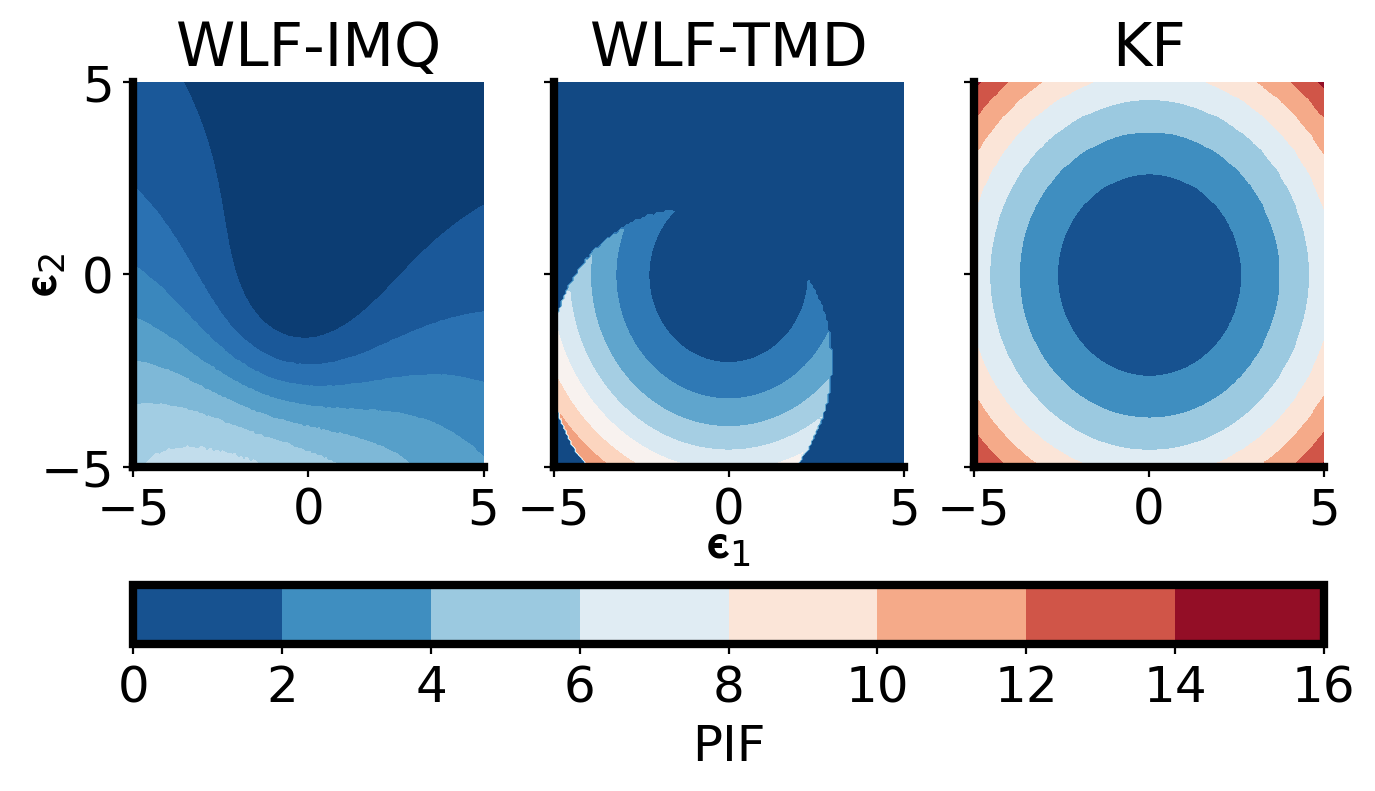

In [42]:
klds = res["kld"]

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(6.4 * 1.2, 4.8 * 0.8),)
norm = Normalize(0, 16)
cmap = "RdBu_r"
c0 = ax[0].contourf(*domain, klds["IMQ"], cmap=cmap, norm=norm)
c1 = ax[1].contourf(*domain, klds["MD"], cmap=cmap, norm=norm)
c2 = ax[2].contourf(*domain, klds["KF"], cmap=cmap, norm=norm)

ax[1].set_xlabel(r"$𝞊_1$", labelpad=-5)
ax[0].set_ylabel(r"$𝞊_2$", labelpad=-10)

ax[0].set_title("WLF-IMQ")
ax[1].set_title("WLF-TMD")
ax[2].set_title("KF")
plt.colorbar(c2, ax=ax, location="bottom", label="PIF", pad=0.2)
plt.savefig("./figures/2d-tracking-grid-pif.png", dpi=300)

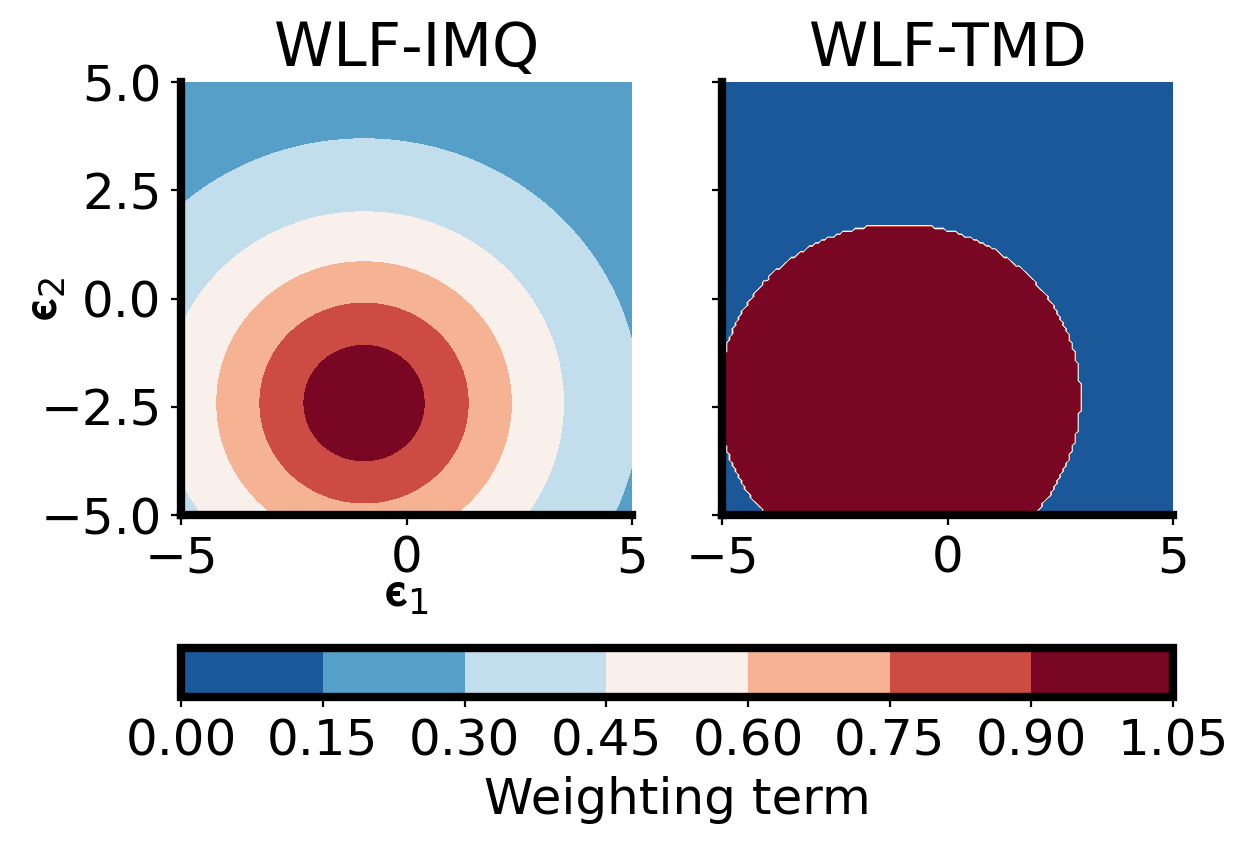

In [41]:
err = res["weighting"]

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(6.4 * 1, 4.8 * 0.9),)
norm = Normalize(0, 1)
cmap = "RdBu_r"
c0 = ax[0].contourf(*domain, err["IMQ"], cmap=cmap, norm=norm)
c1 = ax[1].contourf(*domain, err["MD"], cmap=cmap, norm=norm)
ax[0].set_title("WLF-IMQ")
ax[1].set_title("WLF-TMD")

ax[0].set_xlabel(r"$𝞊_1$", labelpad=-5)
ax[0].set_ylabel(r"$𝞊_2$", labelpad=-10)

plt.colorbar(c1, ax=ax, location="bottom", label="Weighting term", pad=0.2)
plt.savefig("./figures/2d-tracking-grid-weighting-term.png", dpi=300)

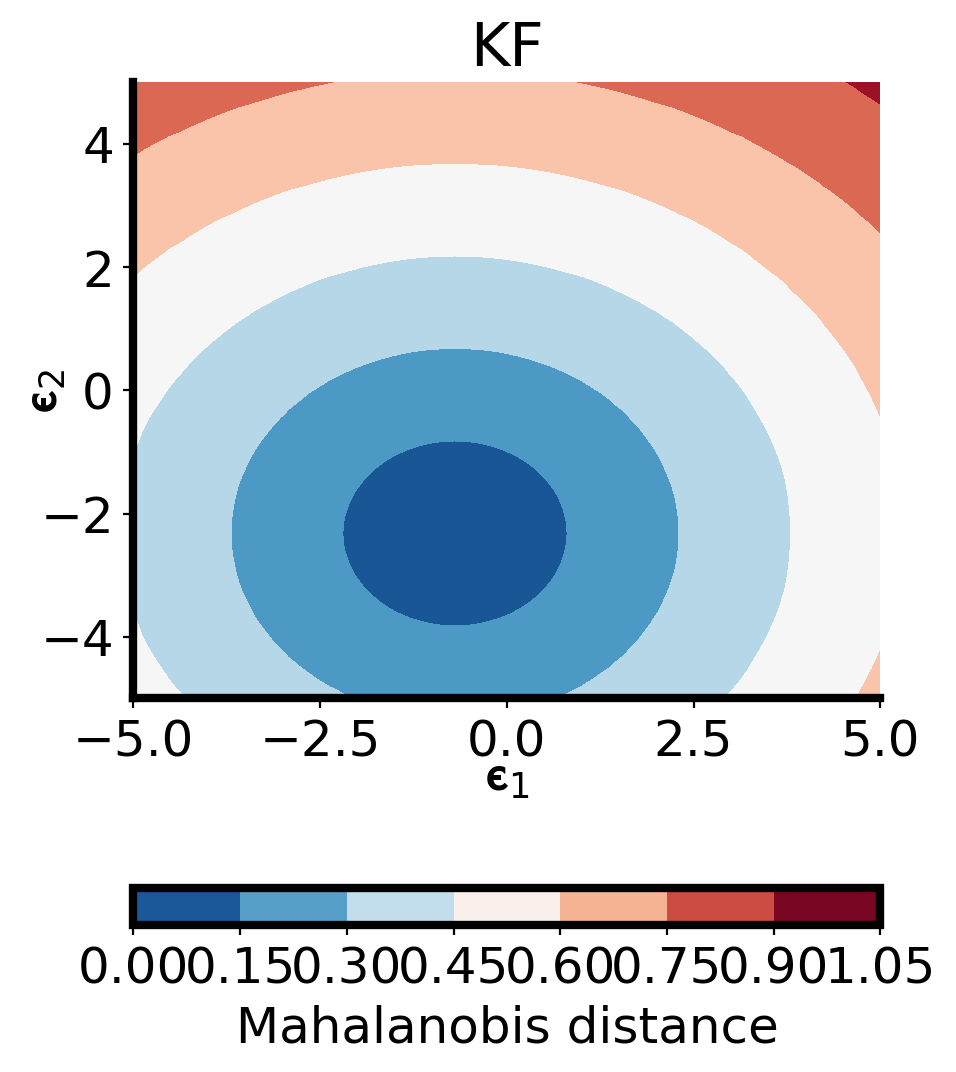

In [40]:
err = res["err-final"]

fig, ax = plt.subplots(figsize=(6.4 * 0.8, 4.8 * 1.2))
norm = Normalize(0, 1)
norm = "linear"
cmap = "RdBu_r"
ax.contourf(*domain, err["KF"], cmap=cmap, norm=norm)

ax.set_xlabel(r"$𝞊_1$", labelpad=-5)
ax.set_ylabel(r"$𝞊_2$", labelpad=-10)
ax.set_title("KF")

plt.colorbar(c1, ax=ax, location="bottom", label="Mahalanobis distance", pad=0.2)
plt.tight_layout()
plt.savefig("./figures/2d-tracking-grid-kf-prior-predictive.png", dpi=300)

### IMQ single

In [23]:
nvals = 150
step = nvals * 1j # Specify total number of points
vmin, vmax = -15, 10
domain = jnp.mgrid[vmin:vmax:step, vmin:6:step]
err = jnp.linspace(vmin, vmax, nvals)

res = vpif_last(err, err)
res = jax.block_until_ready(res)

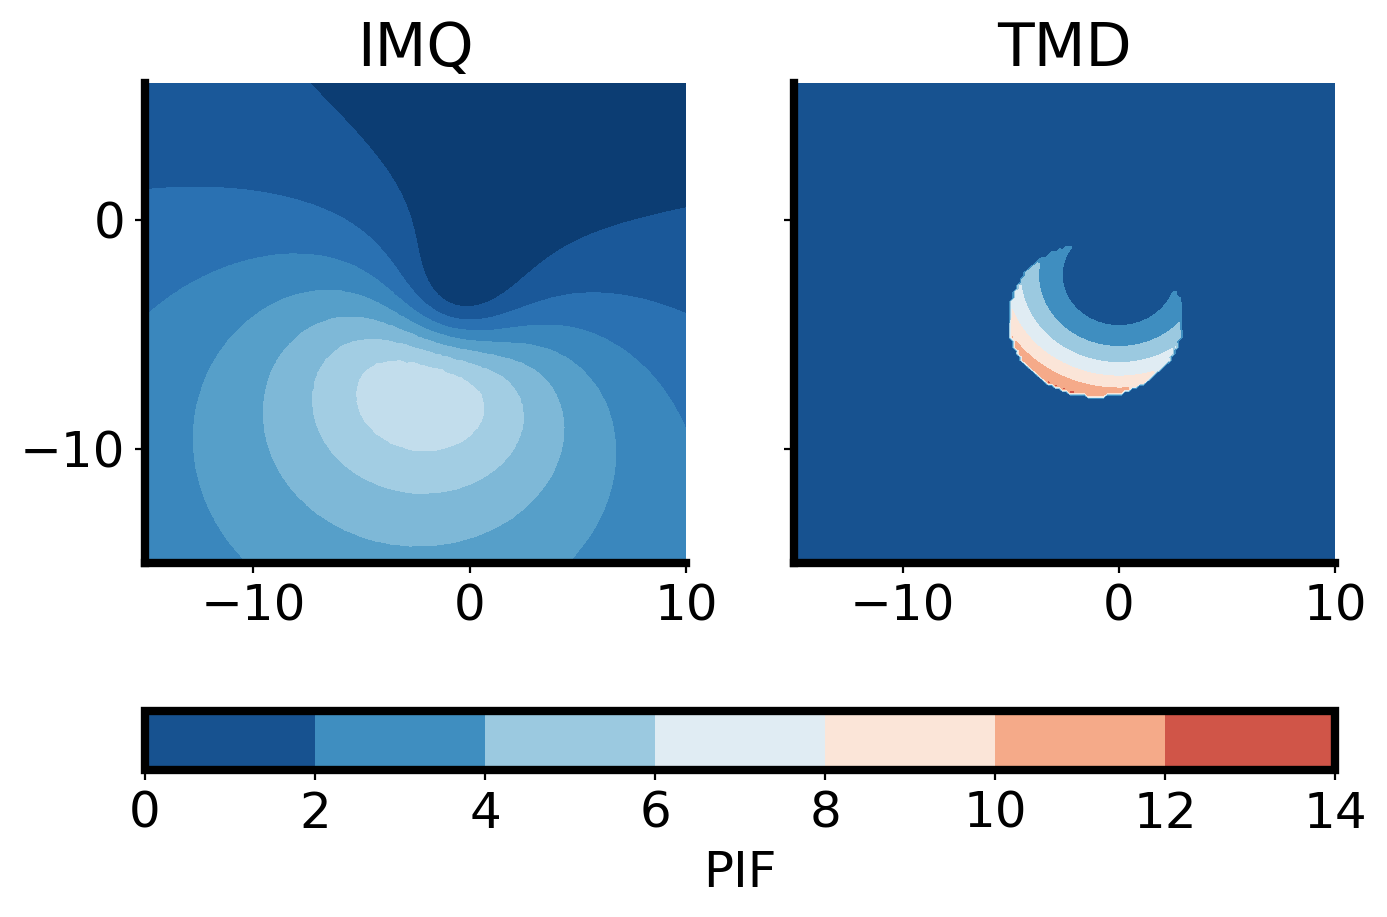

In [25]:
klds = res["kld"]
norm = Normalize(0, 16)
cmap = "RdBu_r"

fig, ax = plt.subplots(1, 2, figsize=(6.4 * 1.2, 4.8), sharey=True)
c0 = ax[0].contourf(*domain, klds["IMQ"], cmap=cmap, norm=norm)
c1 = ax[1].contourf(*domain, klds["MD"], cmap=cmap, norm=norm)

ax[0].set_title("IMQ")
ax[1].set_title("TMD")

plt.colorbar(c1, ax=ax, location="bottom", label="PIF", pad=0.2)
plt.savefig("./figures/2d-tracking-grid-pif-imq-md.png", dpi=300)